In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from tensorflow.keras.applications.resnet50  import preprocess_input
import splitfolders
import warnings
warnings.filterwarnings(action='ignore') 
warnings.simplefilter(action='ignore', category=Warning)

### # Data Overview

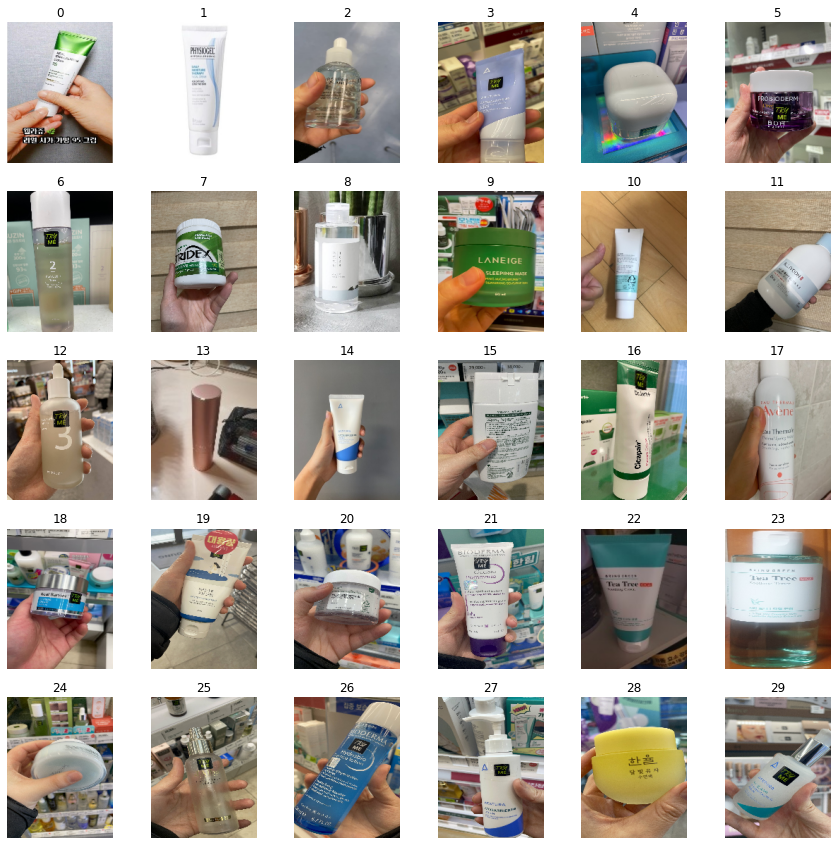

In [36]:
# class 별 이미지 한장씩 확인

fig = plt.figure(figsize=(15, 15))
for i in range(30):
    p = f'E:/olive_young/selected_img/{i}'
    os.chdir(p) 
    files = os.listdir(p)
    img = cv2.imread(files[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f = cv2.resize(img, (150, 200))
    plt.subplot(5,6,i+1)
    plt.imshow(f)
    plt.title(i)
    plt.axis('off')                         

In [99]:
# class 별 이미지 개수 확인

import imghdr

cnt = 0
for i in range(30):
    p = f'E:/olive_young/selected_img/{i}'
    os.chdir(p) 
    files = os.listdir(p)
    cnt += len(files)
    print(f'{i} class: {len(files)}개')
print(f'총 {cnt}장')

0 class: 600개
1 class: 600개
2 class: 600개
3 class: 600개
4 class: 600개
5 class: 600개
6 class: 600개
7 class: 600개
8 class: 600개
9 class: 600개
10 class: 600개
11 class: 600개
12 class: 600개
13 class: 600개
14 class: 600개
15 class: 600개
16 class: 600개
17 class: 600개
18 class: 600개
19 class: 600개
20 class: 600개
21 class: 600개
22 class: 600개
23 class: 600개
24 class: 600개
25 class: 600개
26 class: 600개
27 class: 600개
28 class: 600개
29 class: 600개
총 18000장


### # Train, Validation, Test split

In [ ]:
splitfolders.ratio(
    "E:/olive_young/selected_img", 
    output="E:/olive_young/selected_img2", 
    seed=21, 
    ratio=(0.6, 0.2, 0.2), 
    group_prefix=None)

### # Load Imgs

In [2]:
img_size = (75, 100) # img resizeing

def load_imgs(path, category_num):
    total_imgs = []
    cnt_all = 0
    
    for i in range(category_num):
        p = path + f'{i}'
        os.chdir(p) 
        files = os.listdir(p) 
        globals()[f'img{i}'] = []
        
        cnt = 0
        for file in files:
            src = cv2.imread(file)
            
            if(type(src) == type(None)):
                pass
            else:
                f = cv2.resize(src, img_size)
                globals()[f'img{i}'].append(f)           
        total_imgs += globals()[f'img{i}']
        
    return np.array(total_imgs)

In [6]:
category_num = 30
x_train = load_imgs('E:/olive_young/selected_img2/train/', category_num)
x_val = load_imgs('E:/olive_young/selected_img2/val/', category_num)
x_test = load_imgs('E:/olive_young/selected_img2/test/', category_num)

print('x_train:', x_train.shape)
print('x_val:', x_val.shape)
print('x_test:', x_test.shape)

x_train: (10800, 100, 75, 3)
x_val: (3600, 100, 75, 3)
x_test: (3600, 100, 75, 3)


### # Labeling

In [53]:
y_train, y_val = [], []
for i in range(30):
    y_train += [i]*360
    y_val += [i]*120

In [58]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_val)

### # Imge Augmentation

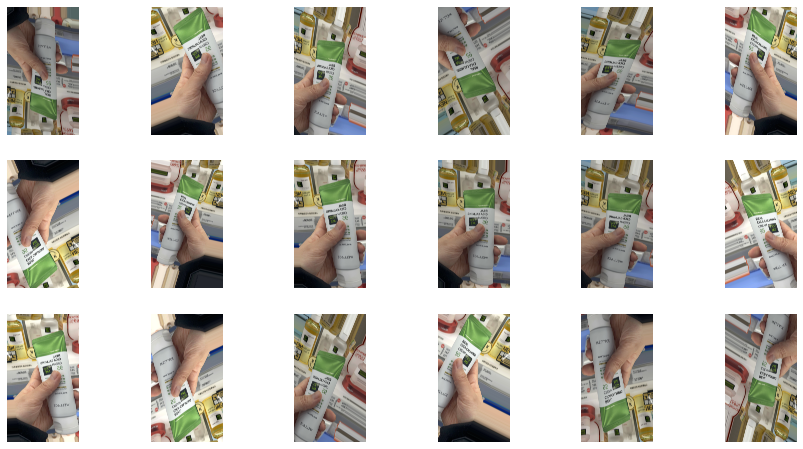

In [98]:
plt.figure(figsize=(15,8))

# expand dimension to one sample
p = f'E:/olive_young/selected_img/0'
os.chdir(p) 
files = os.listdir(p)
img = cv2.imread(files[30])
sample = expand_dims(img, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=10,
    brightness_range=[0.80,1.20],
    fill_mode='nearest'
)

# prepare iterator
iterator = datagen.flow(sample, batch_size=1,seed=42)

for i in range(18):
    plt.subplot(3, 6, i+1)
    # generate batch of images
    batch = iterator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image)

In [140]:
train_dataset = train_datagen.flow_from_directory(
    directory="E:/olive_young/selected_img2/train",
    target_size=(100, 75), 
    batch_size=8,
    shuffle=False,
    class_mode='categorical',
    seed=21
)

batch_size = 3
train_generator = train_datagen.flow_from_directory(
    'E:/olive_young/selected_img2/train',
    target_size=(100, 75),  
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)

Found 10800 images belonging to 30 classes.


In [141]:
class_dictionary = train_dataset.class_indices

#---create a dictionary of labels---
class_dictionary = { value:key for key,value in
    class_dictionary.items()}

#---convert the dictionary to a list---
class_list = [value for _,value in class_dictionary.items()]
print(class_list)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '4', '5', '6', '7', '8', '9']


In [143]:
new_img_num = 6000
new_imgs = []
new_labels = []
for i in range(new_img_num):    

    #---get the batch of augmented images---
    image_batch = train_generator.next()    
    
    #---get the number of images returned---
    images_count = image_batch[0].shape[0]
    
    for c in range(images_count):
        image = image_batch[0][c].astype('uint8')
        new_imgs.append(image)
        label = class_list[np.argmax(image_batch[1][c])]
        new_labels.append(label)

In [147]:
save_to_pickle('E:/olive_young/CNN_mymodel/aug_imgs.pickle', new_imgs)
save_to_pickle('E:/olive_young/CNN_mymodel/aug_labels.pickle', new_labels)

In [8]:
aug_imgs =  pd.read_pickle('E:/olive_young/CNN_mymodel/aug_imgs.pickle')
aug_labels =  pd.read_pickle('E:/olive_young/CNN_mymodel/aug_labels.pickle')

Text(0.5, 1.0, '8')

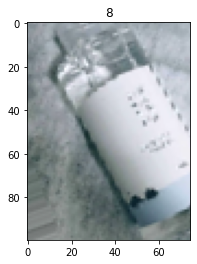

In [146]:
plt.imshow(new_imgs[8])
plt.title(new_labels[8])

In [27]:
new_x_train = np.append(x_train, np.array(aug_imgs)).reshape(-1, 100, 75, 3)
new_x_train.shape

(28800, 100, 75, 3)

In [70]:
new_y_train = np.append(y_train, np.array(aug_labels)).astype('int32')
new_y_train.shape

(28800,)

In [79]:
x_trn = x_train /255
new_x_trn = new_x_train/255
x_v = x_val/255
x_ts = x_test/255

In [93]:
print(x_train.shape, x_trn.shape)
print(new_x_train.shape, new_x_trn.shape)
print(x_test.shape, x_ts.shape)
print(x_val.shape, x_v.shape)

print(y_train.shape, new_y_train.shape)
print(y_test.shape, y_val.shape)

(10800, 100, 75, 3) (10800, 100, 75, 3)
(28800, 100, 75, 3) (28800, 100, 75, 3)
(3600, 100, 75, 3) (3600, 100, 75, 3)
(3600, 100, 75, 3) (3600, 100, 75, 3)
(10800,) (28800,)
(3600,) (3600,)


### # Svae Dataset as Pickle files

In [8]:
import pickle
import inspect

def save_to_pickle(path, variable):
    with open(path, 'wb') as f:
        pickle.dump(variable, f, protocol=pickle.HIGHEST_PROTOCOL)     
    
def retrieve_name(variable):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is variable]

In [91]:
variables = [x_train, x_val, x_test, y_train, y_val, y_test, new_x_train, new_y_train, x_trn, new_x_trn, x_v, x_ts] 
for var in variables:
    save_to_pickle('E:/olive_young/CNN_mymodel/'+ retrieve_name(var)[0] + '.pickle', var)

In [10]:
variables = [new_y_train] 
for var in variables:
    save_to_pickle('E:/olive_young/CNN_mymodel/'+ retrieve_name(var)[0] + '.pickle', var)

In [17]:
# x_train =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_train.pickle')
# x_trn =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_trn.pickle')

# new_x_train =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/new_x_train.pickle')
# new_x_trn =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/new_x_trn.pickle')

# x_test =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_test.pickle')
# x_ts =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_ts.pickle')

# x_val =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_val.pickle')
# x_v =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_v.pickle')

# y_train = pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/y_train.pickle')
# new_y_train =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/new_y_train.pickle')

# y_test =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/y_test.pickle')

# y_val =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/y_val.pickle')

In [ ]:
import pickle5 as pickle
with open('E:/olive_young/CNN_mymodel/dataset/x_train.pickle',"rb") as fr:
    x_train = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/x_trn.pickle',"rb") as fr:
    x_trn = pickle.load(fr, encoding='bytes')
    
with open('E:/olive_young/CNN_mymodel/dataset/new_x_train.pickle',"rb") as fr:
    new_x_train = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/new_x_trn.pickle',"rb") as fr:
    new_x_trn = pickle.load(fr, encoding='bytes')
    
with open('E:/olive_young/CNN_mymodel/dataset/x_test.pickle',"rb") as fr:
    x_test = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/x_ts.pickle',"rb") as fr:
    x_ts  = pickle.load(fr, encoding='bytes')

with open('E:/olive_young/CNN_mymodel/dataset/x_val.pickle',"rb") as fr:
    x_val  = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/x_v.pickle',"rb") as fr:
    x_v = pickle.load(fr, encoding='bytes')
    
with open('E:/olive_young/CNN_mymodel/dataset/y_train.pickle',"rb") as fr:
    y_train  = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/new_y_train.pickle',"rb") as fr:
    new_y_train  = pickle.load(fr, encoding='bytes')
    
with open('E:/olive_young/CNN_mymodel/dataset/y_test.pickle',"rb") as fr:
    y_test  = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/y_val.pickle',"rb") as fr:
    y_val  = pickle.load(fr, encoding='bytes')

In [5]:
print(x_train.shape, x_trn.shape)
print(new_x_train.shape, new_x_trn.shape)
print(x_test.shape, x_ts.shape)
print(x_val.shape, x_v.shape)

print(y_train.shape, new_y_train.shape)
print(y_test.shape, y_val.shape)

(10800, 100, 75, 3) (10800, 100, 75, 3)
(28800, 100, 75, 3) (28800, 100, 75, 3)
(3600, 100, 75, 3) (3600, 100, 75, 3)
(3600, 100, 75, 3) (3600, 100, 75, 3)
(10800,) (28800,)
(3600,) (3600,)
